In [1]:
import os

os.environ["KERAS_BACKEND"] = "tensorflow"

import keras
from keras import layers

import numpy as np
import tensorflow as tf
import gymnasium as gym
import scipy.signal
import matplotlib.pyplot as plt

from environment.models.simple_control_fixed import SimpleControlledFixedEnv

2024-07-18 16:49:46.775043: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-07-18 16:49:46.848645: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


# Hyperparameters & Environment

In [2]:
# Environment Hyperparameters
ENV_DELTA_T = 0.1
ENV_MAX_STEPS = 100
ENV_LATENCY = 0
# ENV ACTIONS
ENV_A_UPPER_BOUND = np.pi
ENV_A_LOWER_BOUND = 0
# ENV SEED
ENV_SEED = 7
# ENV REWARD
ENV_REWARD_TYPE = 'negative' # 'threshold' or 'negative' or 'inverse'
# ENV WITH TIME STATE
ENV_STATE_WITH_TIME = True
ENV_STATE_SIZE = 3 if ENV_STATE_WITH_TIME else 2

# Hyperparameters of the PPO algorithm
EPISODES = 300 # Number of episodes to run
GAMMA = 0.99 # Discount factor
CLIP_RATIO = 0.1 # Clipping parameter epsilon
POLICY_LEARNING_RATE = 5e-4 # Learning rate of policy optimizer
VALUE_FUNCTION_LEARNING_RATE = 1e-3 # Learning rate of value function optimizer
TRAIN_POLICY_ITERATIONS = 280 # Number of iterations of training policy per episode
TRAIN_VALUE_ITERATIONS = 280 # Number of iterations of training value function per episode
LAMBDA = 0.95 # Lambda parameter for GAE
TARGET_KL = 0.01 # Desired KL divergence between old and new policy
HIDDEN_LAYER_SIZES = (256, 256) # Size of hidden layers of neural networks
# actions & observations
NUM_ACTIONS = 2
NUM_OBSERVATIONS = ENV_STATE_SIZE*ENV_LATENCY if ENV_LATENCY > 0 else ENV_STATE_SIZE

# Training note
ALGORITHM_NOTE = "PPO with continous action gaussian policy"
TRAINING_NOTE = "" #"curriculum: restrict QBER to X then Z then both"

# True if you want to render the environment
RENDER = False

## Environment

In [3]:
env = SimpleControlledFixedEnv(noise_model='sinusoidal', sinusoidal_components=1, seed = ENV_SEED, reward_type=ENV_REWARD_TYPE)
# env.max_t = 2
env.delta_t = ENV_DELTA_T
env.setting_state_with_time = ENV_STATE_WITH_TIME
env.fixed_error_ctrl_pump = [0, 0, 0, 0]
env.fixed_error_ctrl_alice = [0, 0, 0, 0]
env.fixed_error_ctrl_bob = [0, 0, 0, 0]
env.fixed_errors_flags = [True, True, True, True, 
                          False, False, True, True, 
                          True, True, True, True]
env.setting_inverse = False
env.latency = ENV_LATENCY
env.max_t = ENV_MAX_STEPS*ENV_DELTA_T

## Env testing

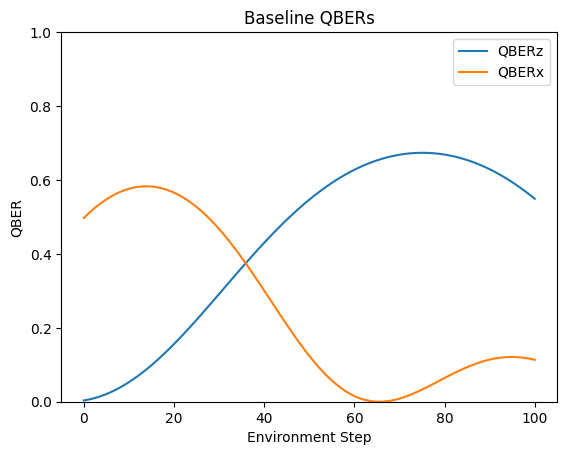

Base reward: -69.18653612549967


In [4]:
state = env.reset()
done = False
baseline_reward = 0
while not done:
    state, reward, done = env.step()
    baseline_reward += reward
    if done:
        break

fig_baseline, ax = plt.subplots()
ax.set_ylim(0, 1)
ax.plot(env.qber_history)
ax.legend(['QBERz', 'QBERx'])
ax.set_title('Baseline QBERs')
ax.set_xlabel('Environment Step')
ax.set_ylabel('QBER')
plt.show()
print("Base reward:", baseline_reward)

In [5]:
# set flags for curriculum training
env.fixed_errors_flags = [True, True, True, True, 
                          False, False, True, True, 
                          True, True, True, True]

# Definitions

In [6]:
def actor_network_wip(input_shape, action_dim):
    inputs = tf.keras.Input(shape=input_shape)
    
    # shared layer
    x = tf.keras.layers.Dense(64, activation='relu')(inputs)
    x = tf.keras.layers.LeakyReLU(alpha=0.1)(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Dense(64, activation='relu')(x)
    x = tf.keras.layers.LeakyReLU(alpha=0.1)(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Dense(16, activation='relu')(x)
    x = tf.keras.layers.LeakyReLU(alpha=0.1)(x)
    x = tf.keras.layers.BatchNormalization()(x)
    
    # mean and std for action 1
    ac1 = tf.keras.layers.Dense(32, activation='relu')(x)
    ac1 = tf.keras.layers.LeakyReLU(alpha=0.1)(ac1)
    mean1 = tf.keras.layers.Dense(action_dim, activation=None)(ac1)
    log_std1 = tf.keras.layers.Dense(action_dim, activation=None)(ac1)
    std1 = tf.exp(log_std1)
    
    # mean and std for action 2
    ac2 = tf.keras.layers.Dense(32, activation='relu')(x)
    ac2 = tf.keras.layers.LeakyReLU(alpha=0.1)(ac2)
    mean2 = tf.keras.layers.Dense(action_dim, activation=None)(ac2)
    log_std2 = tf.keras.layers.Dense(action_dim, activation=None)(ac2)
    std2 = tf.exp(log_std2)
    
    return tf.keras.Model(inputs=inputs, outputs=[mean1, std1, mean2, std2])

def actor_network(input_shape, action_dim):
    inputs = tf.keras.Input(shape=input_shape)
    
    x = tf.keras.layers.Dense(64, activation='relu')(inputs)
    x = tf.keras.layers.LeakyReLU(alpha=0.1)(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Dense(64, activation='relu')(x)
    x = tf.keras.layers.LeakyReLU(alpha=0.1)(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Dense(16, activation='relu')(x)
    x = tf.keras.layers.LeakyReLU(alpha=0.1)(x)
    x = tf.keras.layers.BatchNormalization()(x)
    mean = tf.keras.layers.Dense(action_dim, activation=None)(x)
    log_std = tf.keras.layers.Dense(action_dim, activation=None)(x)
    std = tf.exp(log_std)
    return tf.keras.Model(inputs=inputs, outputs=[mean, std])

In [7]:
def discounted_cumulative_sums(x, discount):
    # Discounted cumulative sums of vectors for computing rewards-to-go and advantage estimates
    return scipy.signal.lfilter([1], [1, float(-discount)], x[::-1], axis=0)[::-1]


class Buffer:
    # Buffer for storing trajectories
    def __init__(self, observation_dimensions, size, gamma=0.99, lam=0.95):
        # Buffer initialization
        self.observation_buffer = np.zeros(
            (size, observation_dimensions), dtype=np.float32
        )
        self.action_buffer = np.zeros((size, NUM_ACTIONS), dtype=np.float32)
        self.advantage_buffer = np.zeros((size, 1), dtype=np.float32)
        self.reward_buffer = np.zeros(size, dtype=np.float32)
        self.return_buffer = np.zeros(size, dtype=np.float32)
        self.value_buffer = np.zeros(size, dtype=np.float32)
        self.logprobability_buffer = np.zeros((size, NUM_ACTIONS), dtype=np.float32)
        self.gamma, self.lam = gamma, lam
        self.pointer, self.trajectory_start_index = 0, 0

    def store(self, observation, action, reward, value, logprobability):
        # Append one step of agent-environment interaction
        self.observation_buffer[self.pointer] = observation
        self.action_buffer[self.pointer] = action
        self.reward_buffer[self.pointer] = reward
        self.value_buffer[self.pointer] = value
        self.logprobability_buffer[self.pointer] = logprobability
        self.pointer += 1

    def finish_trajectory(self, last_value=0):
        # Finish the trajectory by computing advantage estimates and rewards-to-go
        path_slice = slice(self.trajectory_start_index, self.pointer)
        rewards = np.append(self.reward_buffer[path_slice], last_value)
        values = np.append(self.value_buffer[path_slice], last_value)

        deltas = rewards[:-1] + self.gamma * values[1:] - values[:-1]

        self.advantage_buffer[path_slice] = tf.expand_dims(discounted_cumulative_sums(
            deltas, self.gamma * self.lam
        ), -1)
        self.return_buffer[path_slice] = discounted_cumulative_sums(
            rewards, self.gamma
        )[:-1]

        self.trajectory_start_index = self.pointer

    def get(self):
        # Get all data of the buffer and normalize the advantages
        self.pointer, self.trajectory_start_index = 0, 0
        advantage_mean, advantage_std = (
            np.mean(self.advantage_buffer),
            np.std(self.advantage_buffer),
        )
        self.advantage_buffer = (self.advantage_buffer - advantage_mean) / advantage_std
        return (
            self.observation_buffer,
            self.action_buffer,
            self.advantage_buffer,
            self.return_buffer,
            self.logprobability_buffer,
        )


def mlp(x, sizes, activation=keras.activations.tanh, output_activation=None):
    # Build a feedforward neural network
    for size in sizes[:-1]:
        x = layers.Dense(units=size, activation=activation)(x)
    return layers.Dense(units=sizes[-1], activation=output_activation)(x)

# Sample action from actor
@tf.function
def sample_action(observation):
    """
    Sample an action from the Gaussian policy, given an observation.
    
    Returns:
        action: The sampled action.
        log_prob: The log probability of the action under the Gaussian policy.
    """
    mean1, std_dev1, mean2, std_dev2 = actor(observation)
    mean = tf.stack([mean1, mean2], axis=1)
    std_dev = tf.stack([std_dev1, std_dev2], axis=1)
    
    actions = mean + tf.random.normal(tf.shape(mean)) * std_dev
    print(actions)
    return actions, logprobabilities(mean, std_dev, actions)

def logprobabilities(mean, std_dev, action):
    """
    Compute the log probabilities of a given action under a Gaussian policy.
    
    Returns:
        log_prob: The log probability of the action under the Gaussian policy.
    """
    # Normalize the action
    z = (action - mean) / std_dev
    # Compute the log probability
    log_prob = -0.5 * (tf.square(z) + tf.math.log(2 * tf.constant(np.pi)) + 2 * tf.math.log(std_dev))
    # print(log_prob)
    return log_prob

# Train the policy by maxizing the PPO-Clip objective
@tf.function
def train_policy(
    observation_buffer, action_buffer, logprobability_buffer, advantage_buffer
):
    with tf.GradientTape() as tape:  # Record operations for automatic differentiation.
        ratio = tf.exp(
            logprobabilities(*actor(observation_buffer), action_buffer)
            - logprobability_buffer
        )
        min_advantage = tf.where(
            advantage_buffer > 0,
            (1 + CLIP_RATIO) * advantage_buffer,
            (1 - CLIP_RATIO) * advantage_buffer,
        )

        policy_loss = -tf.reduce_mean(
            tf.minimum(ratio * advantage_buffer, min_advantage)
        )
    policy_grads = tape.gradient(policy_loss, actor.trainable_variables)
    policy_optimizer.apply_gradients(zip(policy_grads, actor.trainable_variables))

    kl = tf.reduce_mean(
        logprobability_buffer
        - logprobabilities(*actor(observation_buffer), action_buffer)
    )
    kl = tf.reduce_sum(kl)
    return kl


# Train the value function by regression on mean-squared error
@tf.function
def train_value_function(observation_buffer, return_buffer):
    with tf.GradientTape() as tape:  # Record operations for automatic differentiation.
        value_loss = tf.reduce_mean((return_buffer - critic(observation_buffer)) ** 2)
    value_grads = tape.gradient(value_loss, critic.trainable_variables)
    value_optimizer.apply_gradients(zip(value_grads, critic.trainable_variables))

In [8]:
buffer = Buffer(NUM_OBSERVATIONS, ENV_MAX_STEPS+1)
# Initialize the actor and the critic as keras models
observation_input = keras.Input(shape=(NUM_OBSERVATIONS,), dtype="float32")
logits = mlp(observation_input, list(HIDDEN_LAYER_SIZES) + [NUM_ACTIONS])
# actor = keras.Model(inputs=observation_input, outputs=logits)
actor = actor_network(NUM_OBSERVATIONS, NUM_ACTIONS)
value = tf.squeeze(mlp(observation_input, list(HIDDEN_LAYER_SIZES) + [1]), axis=1)
critic = keras.Model(inputs=observation_input, outputs=value)

# Initialize the policy and the value function optimizers
policy_optimizer = keras.optimizers.Adam(learning_rate=POLICY_LEARNING_RATE)
value_optimizer = keras.optimizers.Adam(learning_rate=VALUE_FUNCTION_LEARNING_RATE)

# Initialize the episode return and episode length
episode_return, episode_length = 0, 0
prev_observation, _ = env.reset()
# for latency

print(prev_observation)

[0.00341999 0.49708549 0.1       ]


2024-07-18 16:49:48.729262: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


# Training Loop

In [9]:
def average_last_n(lst, n=100):
    if len(lst) < n:
        return None
    return sum(lst[-n:])/n

In [10]:
from tqdm import tqdm
import datetime

pbar = tqdm(range(EPISODES))

rewards = []
ep_rewards = []

# Iterate over the number of epochs
for epoch in pbar:    
    # Initialize the sum of the returns, lengths and number of episodes for each epoch
    sum_return = 0
    sum_length = 0
    num_episodes = 0

    # Iterate over the steps of each epoch
    for t in range(ENV_MAX_STEPS):
        # Get the logprobability of the action, action, and take one step in the environment
        if isinstance(prev_observation, list):
            prev_observation = np.concatenate(prev_observation).flatten().tolist()
        prev_observation = tf.expand_dims(
            tf.convert_to_tensor(prev_observation), 0
        )

        action, logprobability_t = sample_action(prev_observation)
        env_actions_converted = action[0].numpy()
        
        # automatically fill alice actions
        a_alice = np.zeros(4)
        for i, ac in enumerate(env_actions_converted):
            a_alice[i] = ac
        
        observation_new, reward, done = env.step(a_alice=a_alice)
        episode_return += reward
        episode_length += 1
        # for latency
        if isinstance(observation_new[0], list):
            observation_new = np.concatenate(observation_new).flatten().tolist()

        # Get the value of the action
        value_t = critic(prev_observation)

        # Store obs, act, rew, v_t, logp_pi_t
        buffer.store(prev_observation, action, reward, value_t, logprobability_t)

        # Update the observation
        prev_observation = observation_new

        # Finish trajectory if reached to a terminal state
        terminal = done
        if terminal or (t == ENV_MAX_STEPS - 1):
            if done:
                last_value = 0     
            else:
                if isinstance(prev_observation, list):
                    prev_observation = np.concatenate(prev_observation).flatten().tolist()
                prev_observation = tf.expand_dims(
                    tf.convert_to_tensor(prev_observation), 0
                ) 
                last_value = critic(prev_observation)
            buffer.finish_trajectory(last_value)
            sum_return += episode_return
            ep_rewards.append(episode_return)
            sum_length += episode_length
            num_episodes += 1
            # print(num_episodes)
            # save qber before reset
            last_qber = env.qber_history
            prev_observation, _ = env.reset()
            # for latency
            if isinstance(prev_observation[0], list):
                prev_observation = np.concatenate(prev_observation).flatten().tolist()
            episode_return, episode_length = 0, 0
            rewards.append(sum_return / num_episodes)
            # implement curriculum learning
            # if epoch > 100:
            #     env.fixed_errors_flags = [True, True, True, True, 
            #                               True, False, True, True, 
            #                               True, True, True, True]
            # if epoch > 200:
            #     env.fixed_errors_flags = [True, True, True, True, 
            #                               False, False, True, True, 
            #                               True, True, True, True]

    # Get values from the buffer
    (
        observation_buffer,
        action_buffer,
        advantage_buffer,
        return_buffer,
        logprobability_buffer,
    ) = buffer.get()

    # Update the policy and implement early stopping using KL divergence
    for _ in range(TRAIN_POLICY_ITERATIONS):
        kl = train_policy(
            observation_buffer, action_buffer, logprobability_buffer, advantage_buffer
        )
        if kl > 1.5 * TARGET_KL:
            # Early Stopping
            break

    # Update the value function
    for _ in range(TRAIN_VALUE_ITERATIONS):
        train_value_function(observation_buffer, return_buffer)

    # Print mean return and length for each epoch
    pbar.set_description(f"Mean Return: {sum_return / num_episodes:.2f}. Mean Length: {sum_length / num_episodes:.2f} Baseline: {baseline_reward:.2f} Last (5): {average_last_n(ep_rewards, 5)}")
    
# some params for saving
total_training_time = pbar.format_dict['elapsed']
avg_time_per_ep = total_training_time/num_episodes
training_completed_timestamp = datetime.datetime.now()

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

Tensor("add:0", shape=(1, 2, 2), dtype=float32)


ValueError: setting an array element with a sequence.

# Plots

In [ ]:
# setup plot saving and data

# save params in csv to avoid file name length issue
import csv

# create UID
import uuid
uid = uuid.uuid4()

# Create a list of parameter names and values
params = [
    ('uid', str(uid)),
    ('date_completed', training_completed_timestamp),
    ('algorithm', ALGORITHM_NOTE),
    ('total_episodes', EPISODES),
    ('seed', env),
    ('gamma', GAMMA),
    ('lambda', LAMBDA),
    ('num_actions', NUM_ACTIONS),
    ('num_states', NUM_OBSERVATIONS),
    ('HIDDEN_LAYER_SIZES', HIDDEN_LAYER_SIZES),
    ('target_kl', TARGET_KL),
    ('train_policy_iterations', TRAIN_POLICY_ITERATIONS),
    ('train_value_iterations', TRAIN_VALUE_ITERATIONS),
    ('max_env_steps', ENV_MAX_STEPS),
    ('latency', ENV_LATENCY),
    ('policy_learning_rate', POLICY_LEARNING_RATE),
    ('value_function_learning_rate', VALUE_FUNCTION_LEARNING_RATE),
    ('clip_ration', CLIP_RATIO),
    ('env_reward_type', ENV_REWARD_TYPE),
    ('env.delta_t', env.delta_t),
    ('env.max_t', env.max_t),
    ('env_type', env.__class__.__name__),
    ('env.fixed_errors_flags', env.fixed_errors_flags),
    ('env.fixed_error_ctrl_pump', env.fixed_error_ctrl_pump),
    ('env.fixed_error_ctrl_alice', env.fixed_error_ctrl_alice),
    ('env.fixed_error_ctrl_bob', env.fixed_error_ctrl_bob),
    ('total_training_time', total_training_time),
    ('avg_time_per_ep', avg_time_per_ep),
    ('baseline_reward', baseline_reward),
    ('convergence_reward', sum_return / num_episodes),
    ('note', TRAINING_NOTE)
]

# File name for parameters, using the same uid
save_dir = 'output/'
params_filename = f"{save_dir}{uid}_params.csv"

# Write parameters to a CSV file
with open(params_filename, 'w', newline='') as csvfile:
    writer = csv.writer(csvfile)
    writer.writerow(['Parameter', 'Value'])
    writer.writerows(params)

## Rewards

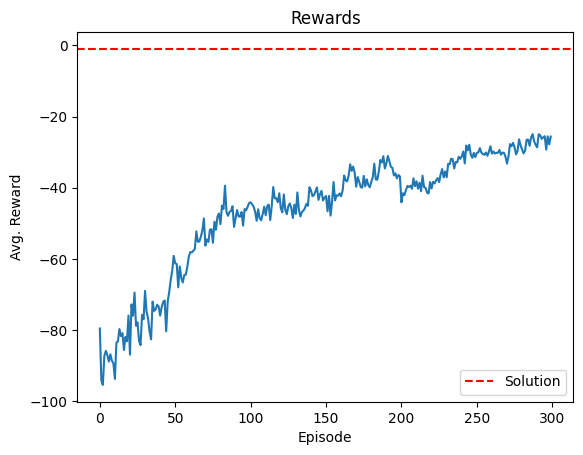

In [ ]:
import matplotlib.pyplot as plt

plt.title('Rewards')
plt.ylabel('Avg. Reward')
plt.xlabel('Episode')
plt.axhline(y=-1, color='red', linestyle='--', label='Solved')
plt.legend(['Solution'])
plt.plot(rewards)


# Save the plot
plot_filename = f"{save_dir}{uid}_rewards.png"
plt.savefig(plot_filename)

## QBERs

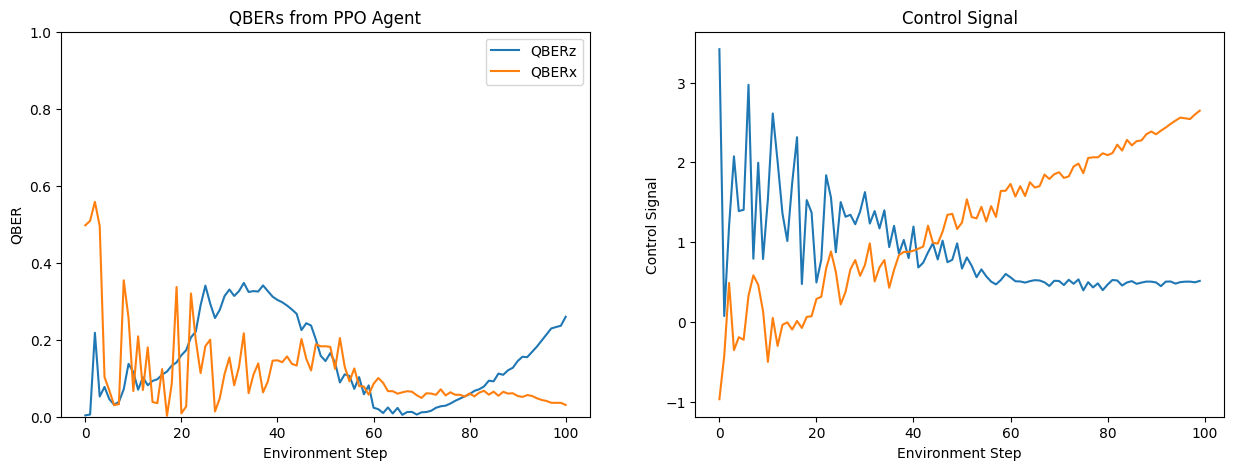

In [ ]:
done = False
prev_observation, _ = env.reset()
episode_return, episode_length = 0, 0

final_rewards = []
ctrl_signal = []

while not done:
    # Convert observation to tensor and expand dimensions for the model
    if isinstance(prev_observation, list):
        prev_observation = np.concatenate(prev_observation).flatten().tolist()
    prev_observation = tf.expand_dims(tf.convert_to_tensor(prev_observation), 0)
    
    # Sample action from the current policy
    action, log_prob = sample_action(prev_observation)
    env_actions_converted = action[0].numpy()
    ctrl_signal.append(env_actions_converted)
    
    # automatically fill alice actions
    a_alice = np.zeros(4)
    for i, ac in enumerate(env_actions_converted):
        a_alice[i] = ac
    
    # Take a step in the environment
    observation_new, reward, done = env.step(a_alice=a_alice)


    episode_return += reward
    episode_length += 1
    
    # Update observation
    prev_observation=[]
    prev_observation = observation_new.copy()

fig, ax = plt.subplots(1,2)
fig.set_size_inches(15, 5)
ax[0].set_ylim(0, 1)
ax[0].set_title('QBERs from PPO Agent')
ax[0].plot(env.qber_history)
ax[0].set_ylabel('QBER')
ax[0].set_xlabel('Environment Step')
ax[0].legend(["QBERz", "QBERx"])

ax[1].set_title('Control Signal')
ax[1].plot(ctrl_signal)
ax[1].set_ylabel('Control Signal')
ax[1].set_xlabel('Environment Step')
plt.show()

In [ ]:
# Save the plot
plot_filename = f"{save_dir}{uid}_QBERS.png"
fig.savefig(plot_filename)
print(uid)

be81f4d9-4258-466d-a538-709286dab4a4


In [ ]:
# fig_baseline
# # Save the baseline plot
# plot_filename = f"{save_dir}{uid}_baseline_QBERS.png"
# fig_baseline.savefig(plot_filename)
# state = env.reset()
# done = False
# baseline_reward = 0
# while not done:
#     state, reward, done = env.step()
#     baseline_reward += reward
#     if done:
#         break

# fig_baseline, ax = plt.subplots()
# ax.set_ylim(0, 1)
# ax.plot(env.qber_history)
# ax.legend(['QBERz', 'QBERx'])
# ax.set_title('Baseline QBERs')
# ax.set_xlabel('Environment Step')
# ax.set_ylabel('QBER')
# plt.show()
# print("Base reward:", baseline_reward)